In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [84]:
data = pd.read_csv('/content/drive/My Drive/data/halong_quality.csv', index_col='date')

In [85]:
data

,pm25,pm10,o3,no2,so2,co
date,,,,,,
3/1/2019,6,6,45,3,500,NaN
3/2/2019,59,55,1,6,500,NaN
3/3/2019,43,28,5,9,500,NaN
3/4/2019,27,3,4,16,500,NaN
3/5/2019,48,17,16,1,500,NaN
...,...,...,...,...,...,...
5/28/2024,64,32,48,9,500,NaN
5/29/2024,47,20,23,8,500,NaN
5/30/2024,40,6,49,9,500,NaN


In [86]:
data.fillna(method='ffill', inplace=True)
scaler = MinMaxScaler()
data['pm25'] = scaler.fit_transform(data[['pm25']])

In [87]:
def create_sequences(data, seq_length=30):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 30
X, y = create_sequences(data['pm25'].values, seq_length)
X = X.reshape((X.shape[0], X.shape[1], 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [88]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(seq_length, 1)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [89]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_11 (Flatten)        (None, 30)                0         
                                                                 
 dense_33 (Dense)            (None, 128)               3968      
                                                                 
 dense_34 (Dense)            (None, 64)                8256      
                                                                 
 dense_35 (Dense)            (None, 1)                 65        
                                                                 
Total params: 12289 (48.00 KB)
Trainable params: 12289 (48.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [90]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/100
42/42 [==============================] - 1s 7ms/step - loss: 0.0323 - val_loss: 0.0168
Epoch 2/100
42/42 [==============================] - 0s 4ms/step - loss: 0.0182 - val_loss: 0.0157
Epoch 3/100
42/42 [==============================] - 0s 3ms/step - loss: 0.0173 - val_loss: 0.0161
Epoch 4/100
42/42 [==============================] - 0s 5ms/step - loss: 0.0172 - val_loss: 0.0160
Epoch 5/100
42/42 [==============================] - 0s 5ms/step - loss: 0.0167 - val_loss: 0.0161
Epoch 6/100
42/42 [==============================] - 0s 5ms/step - loss: 0.0162 - val_loss: 0.0164
Epoch 7/100
42/42 [==============================] - 0s 6ms/step - loss: 0.0159 - val_loss: 0.0165
Epoch 8/100
42/42 [==============================] - 0s 5ms/step - loss: 0.0154 - val_loss: 0.0164
Epoch 9/100
42/42 [==============================] - 0s 5ms/step - loss: 0.0149 - val_loss: 0.0163
Epoch 10/100
42/42 [==============================] - 0s 5ms/step - loss: 0.0145 - val_loss: 0.0166
Epoch 11/

In [91]:
# Predict the next 30 days PM2.5 values
last_sequence = X_test[-1]
predictions = []
current_sequence = last_sequence

for _ in range(30):
    next_value = model.predict(current_sequence[np.newaxis, :, :])[0, 0]
    predictions.append(next_value)
    current_sequence = np.append(current_sequence[1:], [[next_value]], axis=0)

predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
print("Next 30 days PM2.5 predictions:", predictions.flatten())

1/1 [==============================] - 0s 20ms/step
Next 30 days PM2.5 predictions: [24.400427 52.833847 20.392523 23.858004 32.953075 41.20801  20.440702
 27.072268 22.61229  39.982113 41.52678  38.31022  38.115997 12.423367
 14.876923 44.78852  13.099854 23.508833 27.031322 52.855236 30.03158
 31.498533 23.31601  41.876553 40.18127  37.629772 42.970512 28.978727
 19.392721 38.262524]


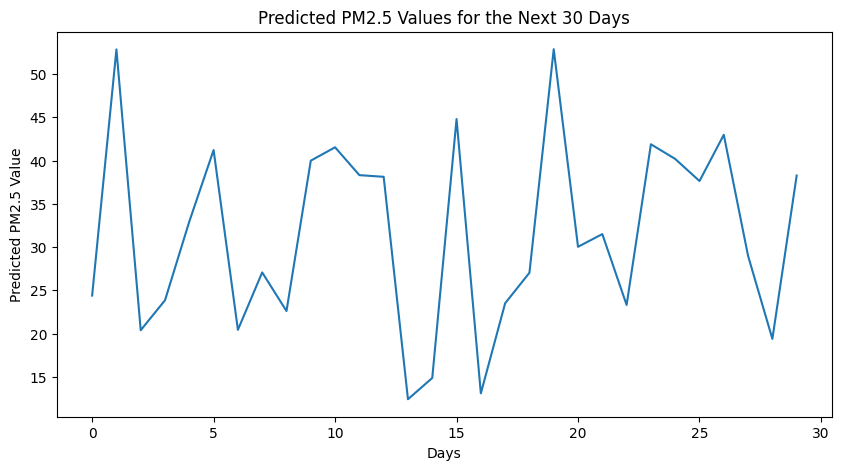

In [92]:
# Plot the predictions in the original scale
plt.figure(figsize=(10, 5))
plt.plot(predictions)
plt.title('Predicted PM2.5 Values for the Next 30 Days')
plt.xlabel('Days')
plt.ylabel('Predicted PM2.5 Value')
plt.show()